In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
gamma = 0.7
# wealth level
eps = 0.01
k_low = 1
k_high = 10
# interest rate
r = 0.05
# depreciation
delta = 0.05
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ks = np.linspace(k_low, k_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vs_new = np.copy(Vs) + 1
# Value iteration
for j in range(1000):
    if j % 10 == 0:
        print(j)
    if max(abs(Vs_new - Vs)) < eps:
        print("converge! ")
        break 
    else:
        Vs = np.copy(Vs_new)
    for i in range(len(ks)):
        k = ks[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((1-delta)*k + (1+r)*(k**gamma - c), ks, Vs) + 
                     np.interp((1-delta)*k + (1-r)*(k**gamma - c), ks, Vs))/2)
        bounds = [(0, k**gamma)]
        res = minimize(obj, eps, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs_new[i] = -res.fun

0
10
20
30
40
50
60
70
80
90
converge! 


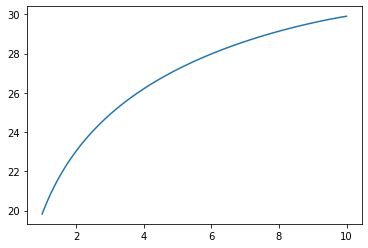

In [3]:
plt.plot(ks,Vs)

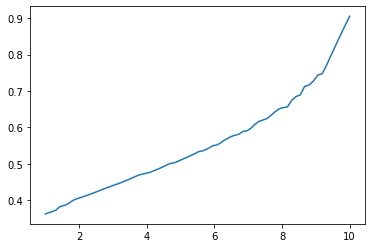

In [4]:
plt.plot(ks, Cs/ks**gamma)

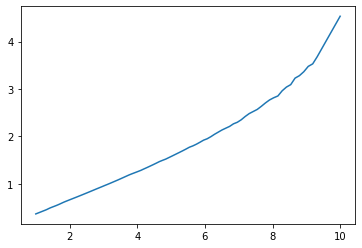

In [5]:
plt.plot(ks,Cs)

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(\frac{1}{1+e^{a w^2 +b w + c}}, \sigma)$


Assume the initial value $a = 0$, $b = 0$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [28]:
T = 20
# simulation step T = 100
def poly(theta, w):
    return theta[0] * (w**2) + theta[1] * w + theta[2]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))


def simSinglePath(theta):
    kPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    k = np.random.uniform(k_low, k_high)
    for t in range(T):
        n = np.random.normal(mu(theta, k), theta[-1])
        n = max(min(n, 1-eps), eps)
        c = n * (k**gamma)
        kPath[t] = k
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            k = (1-delta)*k + (k**gamma-c) * (1+r)
        else:
            k = (1-delta)*k + (k**gamma-c) * (1-r)
    return kPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp**2))
            newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp))
            newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(1))
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False

    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot3(theta):
    plt.plot(ks, Cs, 'b')
    plt.plot(ks, mu(theta, ks)*(ks**gamma), 'r')

0
[0, 0, 0, 0.1]
100
[3.42430356e+02 7.92389446e+00 2.31616903e-01 1.00000000e-01]
200
[3.42430356e+02 7.92389446e+00 2.31616903e-01 1.00000000e-01]
300
[3.42430356e+02 7.92389446e+00 2.31616903e-01 1.00000000e-01]
400
[3.42430356e+02 7.92389446e+00 2.31616903e-01 1.00000000e-01]


KeyboardInterrupt: 

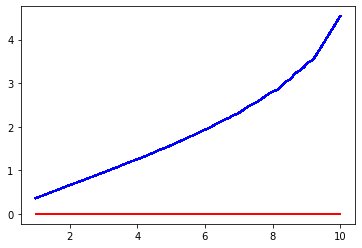

In [26]:
# initial theta
N = 1000
theta = [0,0,0,0.1]
# gradient ascend step size 
alpha = 0.01
# store theta
THETA3 = np.zeros((len(theta)-1,N))
for i in range(N):
    if i%100 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:len(theta)-1]
    plot3(theta)

In [ ]:
plt.plot(THETA3[0,:])

In [ ]:
plt.plot(THETA3[1,:])

In [ ]:
plt.plot(THETA3[2,:])